## Import Modules

In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import sqrt
from sklearn.metrics import mean_squared_error
import tensorflow.keras.backend as K
import pickle
from sklearn.metrics import mean_absolute_percentage_error
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
import os, tqdm

In [33]:
import warnings
warnings.filterwarnings('ignore')

## Preprocessing and Feature Engineering 

In [3]:
data = pd.read_csv('PLID_Bookings_Problem1.csv')

In [4]:
data.sample(5)

,Business Unit,Product Family,PLID,Fiscal Quarter,Fiscal Month,Booked_Qty,Booking_Date
6081,SRSBU,ISR1121,ISR4431/K9,Q3 FY2007,FEB FY2007,2922,01-02-2019
4014,QKBU,N9300,N9K-C93240YC-FX2,Q1 FY2011,OCT FY2011,1145,01-10-2020
2251,CVEBU,CTSPS,CS-DESKPRO-K9,Q1 FY2012,AUG FY2012,727,01-08-2021
8973,UOPBLRBU,C9300,C9300-48P,Q1 FY2008,AUG FY2008,699,01-08-2018
10063,UCEBU,PHONVID,CP-8865-K9,Q3 FY2002,FEB FY2002,6605,01-02-2017


In [14]:
# convert the data to datetime format
data['Booking_Date'] = pd.to_datetime(data['Booking_Date'])

In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10996 entries, 0 to 10995
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Business Unit   10996 non-null  object        
 1   Product Family  10996 non-null  object        
 2   PLID            10996 non-null  object        
 3   Fiscal Quarter  10996 non-null  object        
 4   Fiscal Month    10996 non-null  object        
 5   Booked_Qty      10996 non-null  int64         
 6   Booking_Date    10996 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(5)
memory usage: 601.5+ KB


In [16]:
# We find that the data provided has not nan values
data.isna().sum()

Business Unit     0
Product Family    0
PLID              0
Fiscal Quarter    0
Fiscal Month      0
Booked_Qty        0
Booking_Date      0
dtype: int64

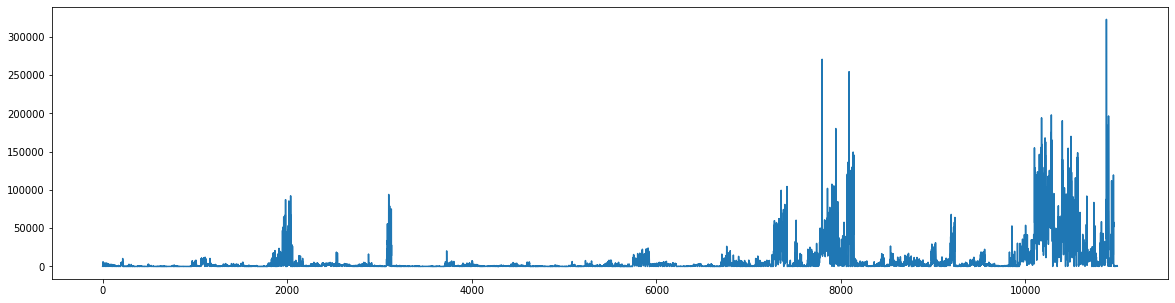

In [20]:
#  Visualizing the data
plt.figure(figsize=(20,5))
ax = data['Booked_Qty'].plot()

In [21]:
# We divide the data into groups
grps = data.groupby('PLID')

In [27]:
for plid in data['PLID'].unique():
    a = grps.get_group(plid)
    a.to_csv(plid+'.csv')
    

## Training the model

Making predictions with **Holt**

In [34]:
main = pd.DataFrame()
for i in tqdm.tqdm(os.listdir("dataset/")):
    
    data = pd.read_csv("dataset/"+i)
    
    df = data[['Booked_Qty', 'Booking_Date']]
    df['Booking_Date'] = pd.to_datetime(df['Booking_Date'])
    df = df.set_index('Booking_Date').sort_values('Booking_Date')
    model_fit = Holt(df, damped=True).fit( smoothing_slope=0.2)
    yhat = model_fit.predict(1)
    yhat = pd.DataFrame(yhat,columns=['Holt_pred'])
    data['Booking_Date'] = pd.to_datetime(data['Booking_Date'])
    df2 = pd.merge(data, yhat, 'left', left_on = 'Booking_Date', right_on = 'Booking_Date')
    
    main = main.append(df2, ignore_index=True)

100%|██████████| 250/250 [00:04<00:00, 53.47it/s]


Making predictions with **Exponential Smoothing**

In [35]:
main = pd.DataFrame()
for i in tqdm.tqdm(os.listdir("dataset/")):
    data = pd.read_csv("dataset/"+i)
    df = data[['Booked_Qty', 'Booking_Date']]
    df['Booking_Date'] = pd.to_datetime(df['Booking_Date'])
    df = df.set_index('Booking_Date').sort_values('Booking_Date')
    model = ExponentialSmoothing(df,trend='additive',damped_trend='True',seasonal_periods='4' )
    model_fit = model.fit(smoothing_level=1.0)
    # make forecast
    df3 = pd.DataFrame(model_fit.forecast(steps=12),columns=['Predict'])
    df3 = df3.reset_index()
    df4 = pd.concat([dates, df3,pd.DataFrame([str(data['PLID'].iloc[0])]*12),pd.DataFrame([str(data['Product Family'].iloc[0])]*12),pd.DataFrame([str(data['Business Unit'].iloc[0])]*12)],ignore_index=True,axis=1)
    df4.columns = ['Dates','ind','Expo_smooth_pred','PLID','Product Family','Business Unit']
    df4 = df4.drop(['ind'],axis=1)
    main=main.append(df4,ignore_index=True)

100%|██████████| 250/250 [00:05<00:00, 25.47it/s]


Make predictions with **Prophet**

In [36]:
main = pd.DataFrame()
for i in tqdm.tqdm(os.listdir("dataset/")):
    data = pd.read_csv("dataset/"+i)
    df = data[['Booked_Qty', 'Booking_Date']]
    df['Booking_Date'] = pd.to_datetime(df['Booking_Date'])
    df = df.sort_values('Booking_Date')
    df = df[['Booking_Date','Booked_Qty']]
    df.columns = ['ds','y']
    m = Prophet()
    m.fit(df)
    yhat = m.predict(df)
    yhat = yhat[['ds','yhat']]
    yhat.columns = ['Booking_Date','Prophet_pred']
    data['Booking_Date'] = pd.to_datetime(data['Booking_Date'])
    df2 = pd.merge(data, yhat, 'left', left_on = 'Booking_Date', right_on = 'Booking_Date')
    main = main.append(df2, ignore_index=True)

100%|██████████| 250/250 [00:04<00:00, 53.47it/s]


Make predictions with **SARIMAX**

In [37]:
main = pd.DataFrame()
for i in tqdm.tqdm(os.listdir("dataset/")):
    data = pd.read_csv("dataset/"+i)
    df = data[['Booked_Qty', 'Booking_Date']]
    df['Booking_Date'] = pd.to_datetime(df['Booking_Date'])
    df = df.sort_values('Booking_Date')
    df = df[['Booking_Date','Booked_Qty']]
    df = df.set_index('Booking_Date')
    model = sm.tsa.statespace.SARIMAX(df, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
    try:results = model.fit()   
    except: continue
    yhat = results.predict(start=0, end=len(df)-1)
    yhat = pd.DataFrame(yhat).reset_index()
    yhat['Booking_Date'] = pd.to_datetime(yhat['Booking_Date'])
    data['Booking_Date'] = pd.to_datetime(data['Booking_Date'])
    df2 = pd.merge(data, yhat, 'left', left_on = 'Booking_Date', right_on = 'Booking_Date')
    main = main.append(df2, ignore_index=True)

100%|██████████| 250/250 [00:04<00:00, 12.49it/s]


## Ensemble and predicting

In [40]:
from sklearn.linear_model  import LinearRegression ,BayesianRidge,ElasticNet
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from xgboost import XGBRegressor,XGBRFRegressor
from sklearn.metrics import mean_squared_error
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_log_error

In [41]:
def train_and_evaluate(model,X_train,y_train, X_val,y_val, **params):
    model.fit(X_train, y_train)
    train_rmse =mean_squared_error(model.predict(X_train), y_train,squared=True)
    val_rmse = mean_squared_error(model.predict(X_val), y_val,squared=True)
    train_rmsle = mean_squared_log_error(abs(model.predict(X_train)), y_train,squared=True)
    val_rmsle = mean_squared_log_error(abs(model.predict(X_val)), y_val,squared=True)

    mape= mean_absolute_percentage_error( y_val,model.predict(X_val))
    smapes=smape(y_val,model.predict(X_val))
    return model, train_rmse, val_rmse,mape, train_rmsle, val_rmsle,smapes

In [42]:
def smape(A, F):
    return 100/len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))

In [ ]:
test = pd.read_csv('data.csv')

In [ ]:
X_test=test[['Dates', 'Expo_smooth_pred', 'holt_pred', 'Prophet_pred', 'SARMAX_pred']]

In [ ]:
X_test1_scaled=scaler.transform(X_test)

In [ ]:
model=XGBRegressor()
model.fit(X_scaled1,y)
y_test=model.predict(X_test1_scaled)

In [ ]:
def size(input):
    if input<50:
        return 'S'
    elif input<100:
        return 'S'
    elif input<200:
        return 'M'
    elif input<300:
        return 'L'
    elif input<400:
        return 'XL'


In [ ]:
test_size = []
for i in y_test:
    test_size.append(size(i))



---

